In [172]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import multiprocessing as mp
from tqdm.notebook import tqdm
import numpy as np
from transformers import pipeline
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.translate.meteor_score import meteor_score
from nltk import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rahad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [136]:
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

In [137]:
df = pd.read_csv('Datasets/flan_t5_large_labelled_train.csv')
tqdm.pandas()

In [126]:
def generate_summary(text):
    input_length = len(text.split())
    max_length = max(30, int(input_length * 0.5))  
    min_length = min(5, int(input_length * 0.2))
    return summarizer(text, max_length=max_length, min_length=min_length, truncation=True)[0]

In [146]:
df_head = df.head(2000)
df_head

,id,dialogue,summary,topic,sentiment
0,train_0,"#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. ...","Mr. Smith's getting a check-up, and Doctor Haw...",get a check-up,positive
1,train_1,"#Person1#: Hello Mrs. Parker, how have you bee...",Mrs Parker takes Ricky for his vaccines. Dr. P...,vaccines,positive
2,train_2,"#Person1#: Excuse me, did you see a set of key...",#Person1#'s looking for a set of keys and asks...,find keys,positive
3,train_3,#Person1#: Why didn't you tell me you had a gi...,#Person1#'s angry because #Person2# didn't tel...,have a girlfriend,negative
4,train_4,"#Person1#: Watsup, ladies! Y'll looking'fine t...",Malik invites Nikki to dance. Nikki agrees if ...,dance,positive
...,...,...,...,...,...
1995,train_1998,#Person1#: I've been worried that Richard is f...,#Person1# tells #Person2# Richard has trouble ...,concentration problems,negative
1996,train_1999,"#Person1#: Hello, Mr. Smith. I'm afraid Dr. Br...",#Person1# calls Mr. Smith to tell him Dr. Brow...,change the appointment,positive
1997,train_2000,"#Person1#: Dad, I need a few supplies for scho...",#Person1# tries to talk her dad into buying a ...,buy school supplies,positive
1998,train_2001,"#Person1#: You look rather pale, Mr. Williams....",Mr. Williams tells #Person1# he ate something ...,a new restaurant,negative


In [147]:
df_head['b_sum'] = df_head['dialogue'].progress_apply(generate_summary)

  0%|          | 0/2000 [00:00<?, ?it/s]

C:\Users\rahad\AppData\Local\Temp\ipykernel_21908\679382749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_head['b_sum'] = df_head['dialogue'].progress_apply(generate_summary)


In [148]:
df_head['bart_summary'] = df_head['b_sum'].apply(lambda x: x['summary_text'] if 'summary_text' in x else None)
df_head.drop('b_sum', axis=1, inplace=True)

C:\Users\rahad\AppData\Local\Temp\ipykernel_21908\3329732939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_head['bart_summary'] = df_head['b_sum'].apply(lambda x: x['summary_text'] if 'summary_text' in x else None)
C:\Users\rahad\AppData\Local\Temp\ipykernel_21908\3329732939.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_head.drop('b_sum', axis=1, inplace=True)


In [149]:
def compute_rouge_scores(observed, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(observed, generated)
    return {
        'rouge1': scores['rouge1'].fmeasure,
        'rouge2': scores['rouge2'].fmeasure,
        'rougeL': scores['rougeL'].fmeasure
    }



In [150]:
df_head['rouge_scores'] = df_head.apply(lambda row: compute_rouge_scores(row['summary'], row['bart_summary']), axis=1)

df_head['rouge1'] = df_head['rouge_scores'].apply(lambda x: x['rouge1'])
df_head['rouge2'] = df_head['rouge_scores'].apply(lambda x: x['rouge2'])
df_head['rougeL'] = df_head['rouge_scores'].apply(lambda x: x['rougeL'])

C:\Users\rahad\AppData\Local\Temp\ipykernel_21908\2812505868.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_head['rouge_scores'] = df_head.apply(lambda row: compute_rouge_scores(row['summary'], row['bart_summary']), axis=1)
C:\Users\rahad\AppData\Local\Temp\ipykernel_21908\2812505868.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_head['rouge1'] = df_head['rouge_scores'].apply(lambda x: x['rouge1'])
C:\Users\rahad\AppData\Local\Temp\ipykernel_21908\2812505868.py:4: SettingWithCopyWarning: 
A 

In [151]:
df_head

,id,dialogue,summary,topic,sentiment,bart_summary,rouge_scores,rouge1,rouge2,rougeL
0,train_0,"#Person1#: Hi, Mr. Smith. I'm Doctor Hawkins. ...","Mr. Smith's getting a check-up, and Doctor Haw...",get a check-up,positive,Dr. Hawkins sees Mr. Smith for a check-up. He ...,"{'rouge1': 0.31746031746031744, 'rouge2': 0.09...",0.317460,0.098361,0.253968
1,train_1,"#Person1#: Hello Mrs. Parker, how have you bee...",Mrs Parker takes Ricky for his vaccines. Dr. P...,vaccines,positive,"Ricky has received his Polio, Tetanus and Hepa...","{'rouge1': 0.2272727272727273, 'rouge2': 0.0, ...",0.227273,0.000000,0.181818
2,train_2,"#Person1#: Excuse me, did you see a set of key...",#Person1#'s looking for a set of keys and asks...,find keys,positive,A man and a woman are looking for a set of key...,"{'rouge1': 0.48780487804878053, 'rouge2': 0.30...",0.487805,0.307692,0.439024
3,train_3,#Person1#: Why didn't you tell me you had a gi...,#Person1#'s angry because #Person2# didn't tel...,have a girlfriend,negative,A man tells his friend he is going to marry hi...,"{'rouge1': 0.2857142857142857, 'rouge2': 0.148...",0.285714,0.148148,0.214286
4,train_4,"#Person1#: Watsup, ladies! Y'll looking'fine t...",Malik invites Nikki to dance. Nikki agrees if ...,dance,positive,"Malik: ""I'll show you all the right moves. My ...","{'rouge1': 0.17647058823529413, 'rouge2': 0.0,...",0.176471,0.000000,0.117647
...,...,...,...,...,...,...,...,...,...,...
1995,train_1998,#Person1#: I've been worried that Richard is f...,#Person1# tells #Person2# Richard has trouble ...,concentration problems,negative,#Person1#: I've been worried that Richard is f...,"{'rouge1': 0.20689655172413793, 'rouge2': 0.0,...",0.206897,0.000000,0.137931
1996,train_1999,"#Person1#: Hello, Mr. Smith. I'm afraid Dr. Br...",#Person1# calls Mr. Smith to tell him Dr. Brow...,change the appointment,positive,"#Person1#: Hello, Mr. Smith. I'm afraid Dr. Br...","{'rouge1': 0.5714285714285715, 'rouge2': 0.399...",0.571429,0.400000,0.571429
1997,train_2000,"#Person1#: Dad, I need a few supplies for scho...",#Person1# tries to talk her dad into buying a ...,buy school supplies,positive,"""I'm in Grade 8 now, and I need real supplies ...","{'rouge1': 0.13114754098360656, 'rouge2': 0.03...",0.131148,0.033898,0.098361
1998,train_2001,"#Person1#: You look rather pale, Mr. Williams....",Mr. Williams tells #Person1# he ate something ...,a new restaurant,negative,Jerry Williams was sick the next day after eat...,"{'rouge1': 0.4150943396226415, 'rouge2': 0.078...",0.415094,0.078431,0.264151


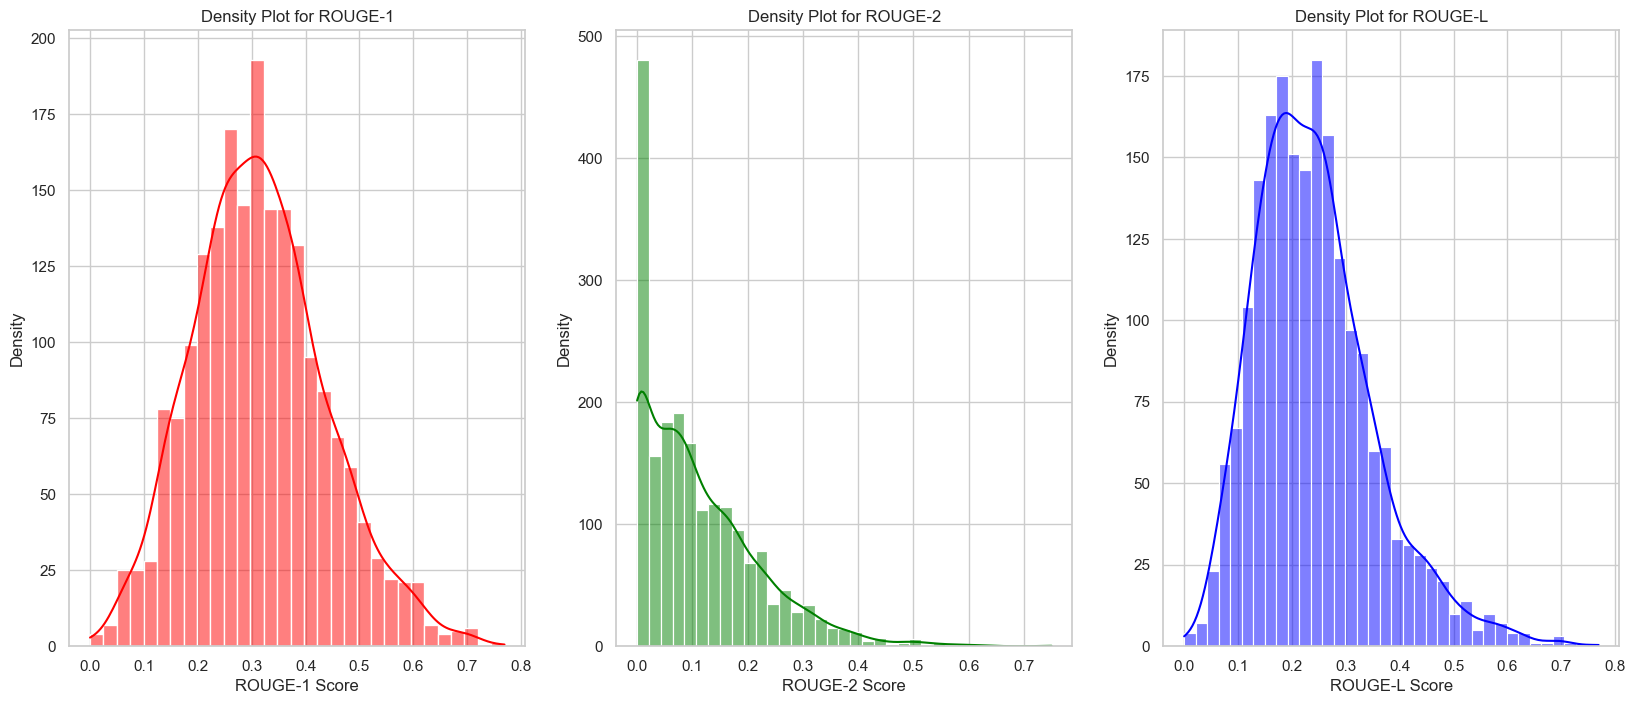

In [163]:
sns.set(style="whitegrid")

plt.figure(figsize=(20, 8))
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
sns.histplot(df_head['rouge1'], kde=True, color="red")
plt.title('Density Plot for ROUGE-1')
plt.xlabel('ROUGE-1 Score')
plt.ylabel('Density')

# Create a subplot for rouge2
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
sns.histplot(df_head['rouge2'], kde=True, color="green")
plt.title('Density Plot for ROUGE-2')
plt.xlabel('ROUGE-2 Score')
plt.ylabel('Density')

# Create a subplot for rougeL
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
sns.histplot(df_head['rougeL'], kde=True, color="blue")
plt.title('Density Plot for ROUGE-L')
plt.xlabel('ROUGE-L Score')
plt.ylabel('Density')


# Show the plot
plt.show()

In [180]:
def calculate_meteor(observed, generated):
    hypothesis_tokens = word_tokenize(generated)
    
    observed_tokens = [word_tokenize(observed)]
    generated_tokens = word_tokenize(generated)
    
    score = meteor_score(observed_tokens, generated_tokens)
    return score


In [181]:
df_head['meteor'] = df_head.apply(lambda x: calculate_meteor(x['summary'], x['bart_summary']), axis=1)

C:\Users\rahad\AppData\Local\Temp\ipykernel_21908\2362160964.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_head['meteor'] = df_head.apply(lambda x: calculate_meteor(x['summary'], x['bart_summary']), axis=1)


Text(0, 0.5, 'Density')

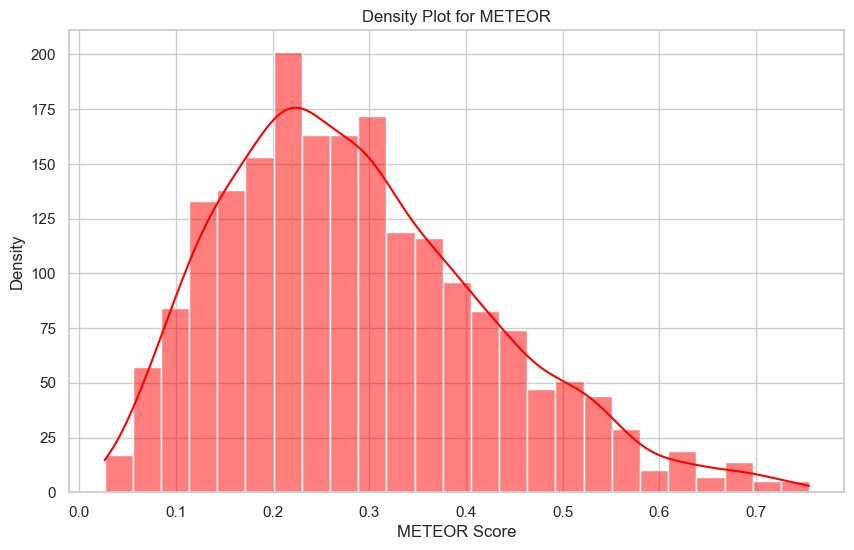

In [183]:
sns.set(style="whitegrid")

# Create a figure with defined size
plt.figure(figsize=(10, 6))

# Create a subplot for rouge1
sns.histplot(df_head['meteor'], kde=True, color="red")
plt.title('Density Plot for METEOR')
plt.xlabel('METEOR Score')
plt.ylabel('Density')
